## 3D Volume-to-Volume Translation with Conditional Adversarial Networks (GAN's)
import all necessary libs and frameworks

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.filters import gaussian
import itertools
from datetime import datetime
import json
import cv2
from IPython.display import clear_output

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, './scripts')

import helper as hp
import data_loader3D as dl
import deconvolution as deconv
import vol2vol as v2v
#import plot3DVol as plot3D

from NanoImagingPack.microscopy import PSF3D
from NanoImagingPack.view import view

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### look for the data

In [4]:
dataset_name = 'VascuSynth'

path = glob('./data/3D/{0}/train/*'.format(dataset_name))
path = [item for item in path if item.endswith('.tif') or item.endswith('.tiff')]

dl.print_volume_dimension(path, max_print=5)

dimensions of volumes:
0 (101, 101, 101)
1 (101, 101, 101)
2 (101, 101, 101)
3 (101, 101, 101)
4 (101, 101, 101)


### plot the distribution of a random image and the result after histogram equalization

(101, 101) 0.0 0.8742492782842862 (10201,)
unique bins of gray values of original volume:			 1503
unique bins of gray values after histogram eqaulization:	 981


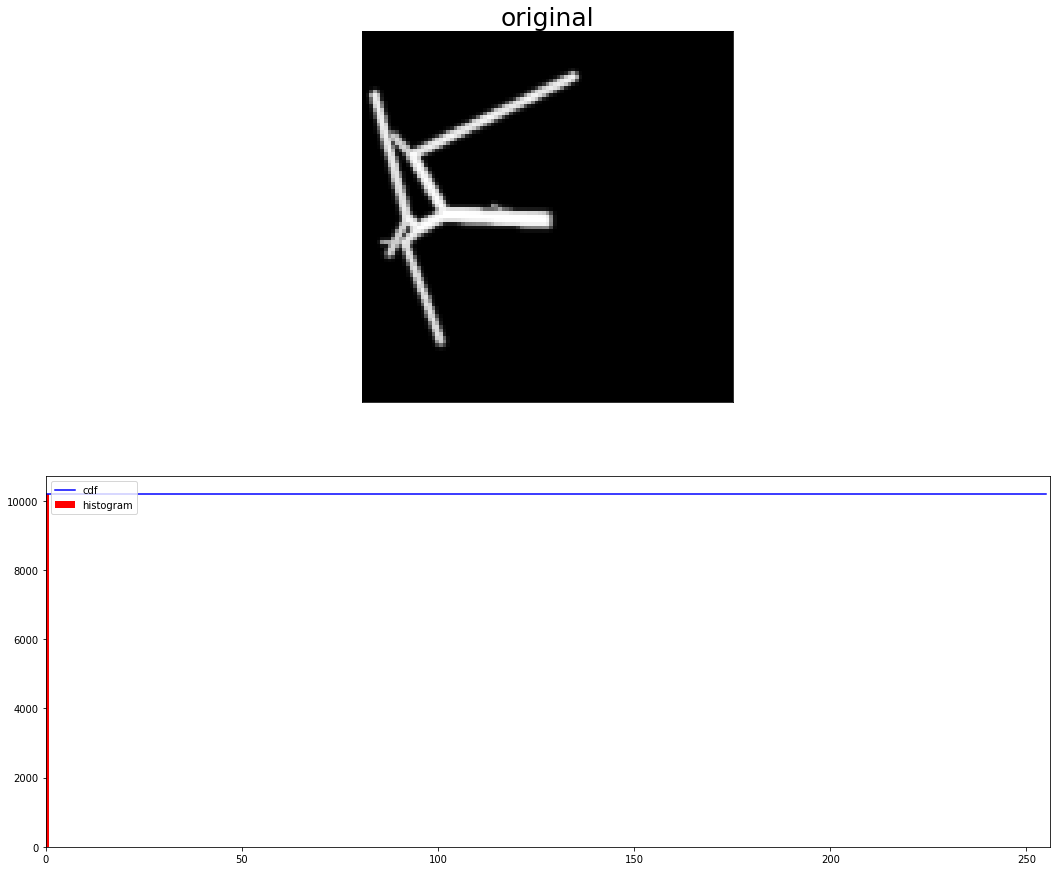

In [5]:
from skimage import exposure

vol = io.imread(np.random.choice(path, size=1)[0])
vol = gaussian(vol, sigma=0.5)
img = np.max(vol, axis=2)#/127.5-1
print(img.shape, np.min(img), np.max(img), img.flatten().shape)

print('unique bins of gray values of original volume:\t\t\t', len(np.unique(img)))

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

# p2, p98 = np.percentile(img, (2, 98))
# print(p2, p98)
# equ = exposure.rescale_intensity(img, in_range='image', out_range=(p2, p98))
equ = exposure.equalize_adapthist(img, clip_limit=0.02)
# equ = exposure.equalize_hist(img)
print('unique bins of gray values after histogram eqaulization:\t', len(np.unique(equ)))
# print(np.unique(equ))

fig = plt.figure(figsize=(18, 15))
plt.subplot(211); 
plt.imshow(img, cmap='gray'); plt.xticks([]); plt.yticks([]); plt.title('original', fontsize=25)
plt.subplot(212);
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

# plt.subplot(223);
# plt.imshow(equ, cmap='gray'); plt.xticks([]); plt.yticks([]); plt.title('equalized', fontsize=25)
# hist_eq,bins_eq = np.histogram(img.flatten(),256,[0,256])
# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()
# plt.subplot(224);
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(equ.flatten())#,256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

from skimage import data, img_as_float
from skimage import exposure
import cv2

# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(img)

# res = np.hstack((img,cl1)) #stacking images side-by-side
# plt.imshow(res)

### create TFRecord file

In [6]:
vol_orginal_size = (101,101,101) 
vol_resize_size = (64,64,64)

with open('./scripts/config.json') as json_data:
    otf_info = json.load(json_data)['OTF']

data_loader = dl.DataLoader3D(micro_noise=10000, 
                              d_name=dataset_name, 
                              manipulation='NONE', 
                              vol_original=vol_orginal_size,
                              vol_resize=vol_resize_size,
                              otf=otf_info,
                              augm_factor=0)

filename = './data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

### test the 3D psf for a random volume

8 [0.         0.12156863 0.24705882 0.37254902 0.49803922 0.62352941
 0.74901961 0.8745098 ]
43979 [0.00000000e+00 2.23340398e-12 4.46680795e-12 4.53885324e-12
 6.77225722e-12 6.84430251e-12 9.14975177e-12 1.13831557e-11
 1.14552010e-11 1.36886050e-11]
image before cut/resize in x/y dimension:	 (101, 101, 101)
image after cut/resize in x/y dimension:	 (64, 64, 64)


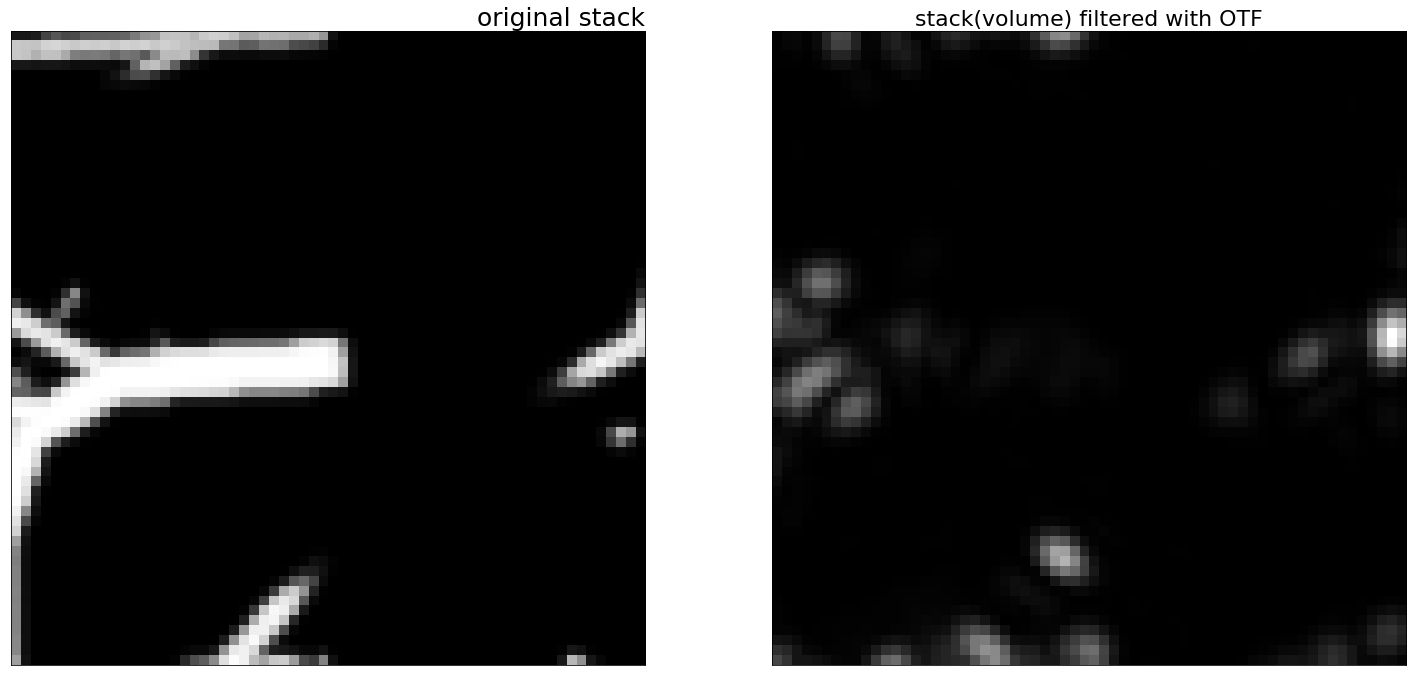

Wall time: 2.86 s


In [7]:
%%time 

sample = np.random.choice(path, size=1)[0]

vol = io.imread(sample)/255.
print(len(np.unique(vol)), np.unique(vol)[:10])
vol = gaussian(vol, sigma=0.5)
print(len(np.unique(vol)), np.unique(vol)[:10])
print('image before cut/resize in x/y dimension:\t', vol.shape)

# compute OTF
otf = PSF3D(im=vol.shape, ret_val = 'OTF')

# perform convolution on stack with computed otf (with numpy) and add noise
vol_otf = deconv.conv3d_fft(vol, otf)
vol_otf = data_loader.put_noise(vol_otf)

vol = data_loader.cut_volume(vol, vol_resize_size, centered=True)
vol_otf = data_loader.cut_volume(vol_otf, vol_resize_size, centered=True)
print('image after cut/resize in x/y dimension:\t', vol.shape)

f = plt.figure(figsize=(25,15))
plt.subplot(121); 
temp = plt.imshow(np.max(vol, axis=2), cmap='gray');
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25, loc='right')
plt.subplot(122); 
temp = plt.imshow(np.max(vol_otf, axis=2), cmap='gray');
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
plt.show()

### plot entire volume and default PSF

In [8]:
#%matplotlib notebook

# dub_path = '../data/3D/dub/dub01.tif'
# dub = io.imread(dub_path)
# print(dub.shape)
# dub = hp.swapAxes(dub, swap=True)
# print(dub.shape)

# vol_3D = plot3D.Interactive_3DVolume(vol=dub)
# vol_3D.multi_slice_viewer()

# Christians tool 
# v = view(dub, show_hist=False)

### and initialize the volume to volume GAN

First we have a look for network-configuration.<br>
**Important configurations are:**
- manipulation of the stack axes (MANIPULATION_STACKS) -> influence on the quality of the image
- using GANHACK -> techniques for improve GAN training
- the NETWORK_DEPTH -> the depth has a large impact on the duration of the GAN-training
- learning-rate of the optimizer

In [9]:
import json 
import pprint

with open('./scripts/config.json') as json_data:
    json_file = json.load(json_data)
    selected = json_file['selected']
    pprint.pprint(selected)

{'ADAM_OPTIMIZER_LEARNRATE': 7e-05,
 'BATCH_NORMALIZATION': True,
 'BATCH_SIZE': 2,
 'COMBINED_LOSS': ['mse', 'mae'],
 'DATASET_NAME': 'VascuSynth',
 'DATA_AUGMENTATION_FACTOR': 2,
 'DROPOUT': 0.03,
 'D_LOSS': 'mse',
 'FLIP_LABEL_PROB': 0.03,
 'GANHACKS': False,
 'GAUSSIAN_NOISE_TO_G': 0.03,
 'INCREASE_LOSS_WEIGHTS': 1.1,
 'INSTANCE_NOISE': False,
 'LOSS_WEIGHTS': [1, 100],
 'MANIPULATION_STACKS': 'NONE',
 'MICRO_NOISE_NPhot': 1000,
 'NETWORK_DEPTH': 'HIGH',
 'NUMBER_ONLY_TRAIN_G': 1,
 'ONE-SIDED-LABEL': 1.1,
 'POOLING': 'AVERAGE',
 'RESIZE': {'depth': 32, 'height': 64, 'width': 64},
 'SAVE_LOGS': False,
 'SAVE_MODEL': False,
 'SAVE_TABLE_IMAGES': True,
 'SAVE_VOLUME': False}


In [10]:
vol_orginal_size = (101,101,101)
print('volume orginial size:\t\t', vol_orginal_size)
print('volume cut (resize):\t\t', selected['RESIZE'])
print('dataset name:\t\t\t', selected['DATASET_NAME'])

grid_search = json_file['grid_search']
keys, values = zip(*grid_search.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

print('number of all hyper parameter combinations:\t', len(experiments))

volume orginial size:		 (101, 101, 101)
volume cut (resize):		 {'width': 64, 'height': 64, 'depth': 32}
dataset name:			 VascuSynth
number of all hyper parameter combinations:	 3


### create gan object and train the GAN

dependent for a grid search

In [11]:
# release GPU

from keras import backend as K
import gc

def clear_models_session():    
    try:
        del gan, discriminator, combined, generator 
    except:
        pass
#         print('models not available')
    K.clear_session()
    gc.collect()
        
clear_models_session()

In [ ]:
%%time

gridSearch = False
epochs, s_interval = 150, 22 

if gridSearch:
    for hyper_parameter in experiments:
        selected.update(hyper_parameter)
        clear_output()
#         pprint.pprint(selected)
        print('---------------------------------------------------------')
               
        try:
            gan = v2v.Pix3Pix(vol_original=vol_orginal_size, grid_search=gridSearch, parameter=selected)
            gan.train(epochs=epochs, sample_interval=s_interval)
            clear_models_session()
        except:
            clear_models_session()
            continue
else:
    clear_models_session()
    
    gan = v2v.Pix3Pix(vol_original=vol_orginal_size, grid_search=gridSearch)
    gan.train(epochs=epochs, sample_interval=s_interval)

discriminator-model in/output:	 (?, 64, 64, 32, 1) (?, 64, 64, 32, 1) 
				 (?, 4, 4, 2, 1)
generator-model input:		 (?, 64, 64, 32, 1)
downsampling:			 (?, 32, 32, 16, 64)
downsampling:			 (?, 16, 16, 8, 128)
downsampling:			 (?, 8, 8, 4, 256)
downsampling:			 (?, 4, 4, 2, 512)
downsampling:			 (?, 2, 2, 1, 512)
downsampling:			 (?, 1, 1, 1, 512)
upsampling:			 (?, 2, 2, 1, 512)
upsampling:			 (?, 4, 4, 2, 512)
upsampling:			 (?, 8, 8, 4, 256)
upsampling:			 (?, 16, 16, 8, 128)
upsampling:			 (?, 32, 32, 16, 64)
generator-model output:		 (?, 64, 64, 32, 1)
finish Pix3Pix __init__

[Epoch 0/149][Batch 0/53] [D loss: ----, acc: ----] [G loss: 93.190353] t: 0:00:20.360578 False A
[Epoch 0/149][Batch 0/53] [D loss: ----, acc: ----] [G loss: 89.363327] t: 0:00:21.498724 False
[Epoch 0/149][Batch 1/53] [D loss: ----, acc: ----] [G loss: 75.127289] t: 0:00:36.157453 False A
[Epoch 0/149][Batch 1/53] [D loss: ----, acc: ----] [G loss: 59.651646] t: 0:00:36.476011 False
[Epoch 0/149][Batch 2/5

## plot output of GAN with a max-projection from the last trained model,

after that plot the L1 / L2-norm of the last trained model output

In [23]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
model_vols = [item for item in model_vols if not "_VOLUMES" in item]

temp = [str(f).split('_')[1:] for f in model_vols]
temp = [f[0].split('-')+(f[1:]) for f in temp]
temp = [list(map(int, f)) for f in temp]
temp = [datetime(f[0], f[1], f[2], f[3], f[4], f[5]) for f in temp]
max_date = str(np.char.replace(np.char.replace(str(max(temp)),' ','_'), ':', '_'))
last_model = [m for m in model_vols if max_date in m]

last_model

['images/VascuSynth\\VascuSynth_2018-11-05_17_30_12']

plotted volume: images/VascuSynth\VascuSynth_2018-11-05_17_30_12\49_22.png


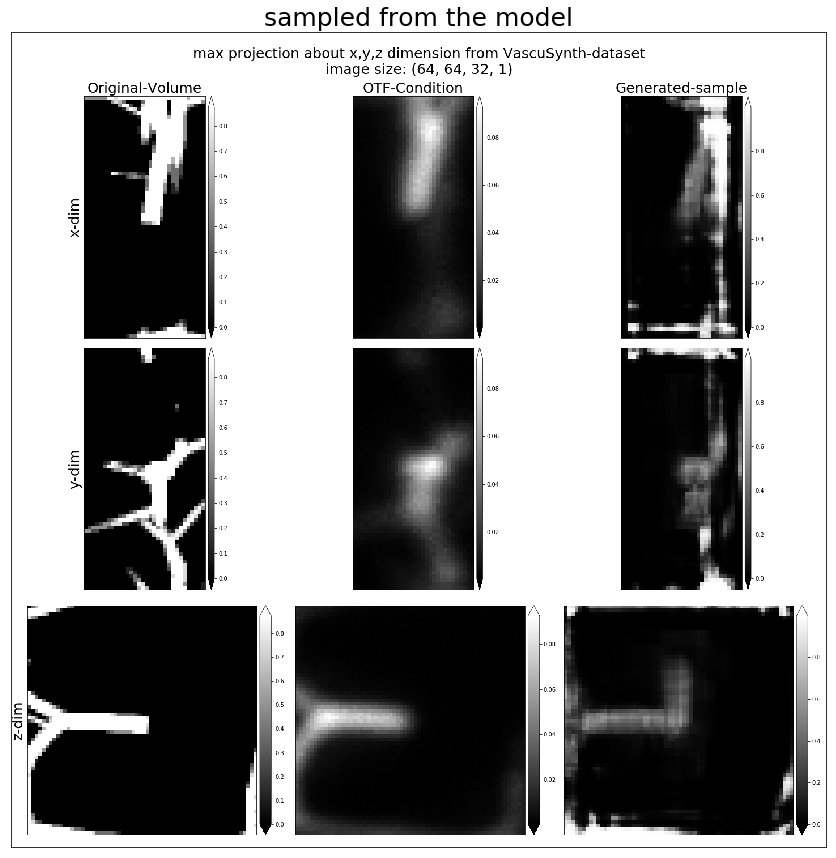

In [24]:
volumes = glob(last_model[0]+'/*')
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)

print('plotted volume:', volumes)
f = plt.figure(figsize=(15,15))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

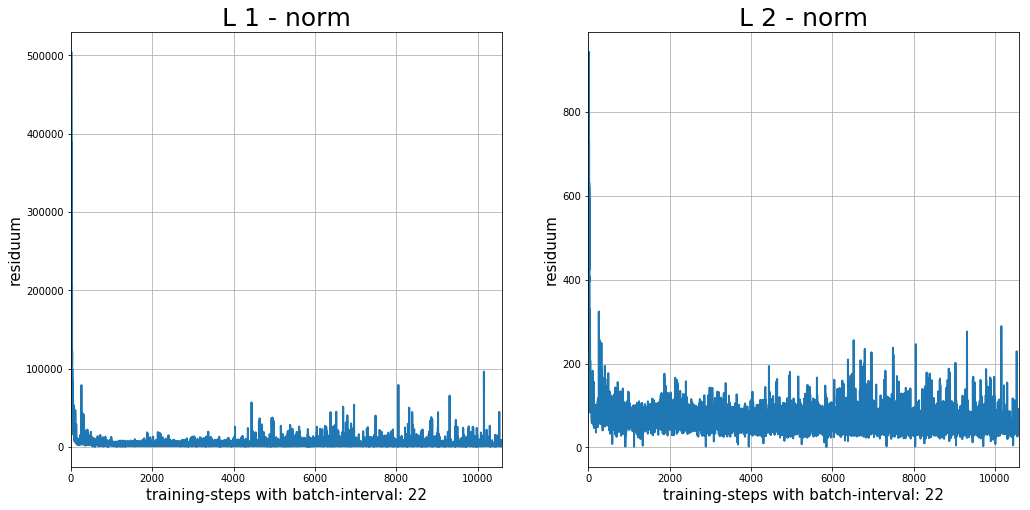

In [25]:
csv_file = '{0}/{1}.csv'.format(last_model[0], max_date)
df = pd.read_csv(csv_file)

f = plt.figure(figsize=(17,8))
plt.subplot(121); df['L_1'].plot(linewidth=2); plt.grid(True); 
plt.title('L 1 - norm', fontsize=25); plt.ylabel('residuum', fontsize=15);
plt.xlabel('training-steps with batch-interval: {}'.format(s_interval), fontsize=15)
plt.subplot(122); df['L_2'].plot(linewidth=2); plt.grid(True); 
plt.title('L 2 - norm', fontsize=25); plt.ylabel('residuum', fontsize=15);
plt.xlabel('training-steps with batch-interval: {}'.format(s_interval), fontsize=15)
plt.show()

### validate trained model on other volume-images

In [58]:
_, generator = hp.model_loader('2018_10_8', '15_03_19_gene_10%')

Loaded model from disk


In [34]:
### TEST
from keras.models import model_from_yaml

# load YAML and create model
yaml_file = open('model_G.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
generator = model_from_yaml(loaded_model_yaml)
# load weights into new model
generator.load_weights("G.h5")
print("Loaded model from disk")

Loaded model from disk


../data/3D/VALIDATION/dub\dub40.tif
original shape	 (768, 512, 33)
cutted shape	 (64, 64, 32)
resized shape	 (64, 64, 64)


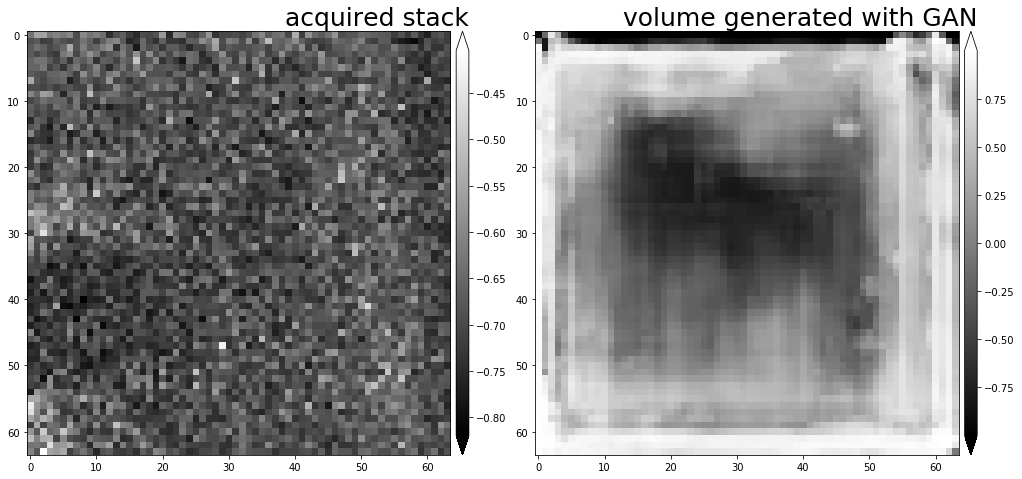

Wall time: 1.15 s


In [44]:
%%time

# v_path = np.random.choice(glob('../data/3D/\VascuSynth/test/*'), size=1)[0]; print(v_path)
v_path = np.random.choice(glob('./data/3D/VALIDATION/dub/*'), size=1)[0]                          
# v_path = ''../data/3D/VALIDATION/dub/dub12.tif'
# v_path = '../data/3D/VALIDATION/HEART/HEART.tif'
# v_path = '../data/3D/VALIDATION/synchrotron_acquisitions_neuroblastoma_cells/example04.tif'
print(v_path)

vol_validation = np.swapaxes(io.imread(v_path), 0, 2)
vol_validation = vol_validation/127.5 - 1.
print('original shape\t', vol_validation.shape)

vol_validation = gan.data_loader.cut_volume(vol_validation, (64,64,32), centered=False)
print('cutted shape\t', vol_validation.shape)

vol_validation = np.pad(vol_validation, pad_width=((0,0),(0,0),(0,32)), mode='reflect')
# from skimage.transform import resize
# vol_validation = resize(vol_validation, output_shape=(64,64,16))
print('resized shape\t', vol_validation.shape)

vol_validation = np.expand_dims(vol_validation, axis=4)
vol_validation = np.expand_dims(vol_validation, axis=0)
vol_validation_gan = generator.predict(vol_validation).squeeze()
# vol_validation_gan = generator.predict(vol_validation).squeeze()

f = plt.figure(figsize=(15,10))
plt.subplot(121); 
temp = plt.imshow(np.max(vol_validation.squeeze(), axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(vol_validation_gan, axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

../data/3D/VALIDATION/dub\dub12.tif
original shape	 (768, 512, 33)
cutted shape	 (64, 64, 32)
resized shape	 (64, 64, 64)


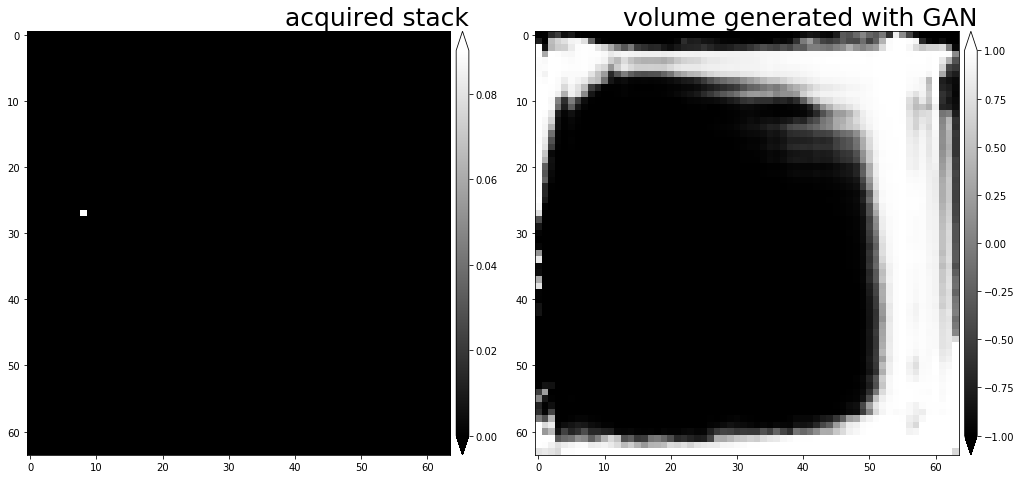

Wall time: 1.41 s


In [39]:
%%time

# v_path = np.random.choice(glob('../data/3D/\VascuSynth/test/*'), size=1)[0]; print(v_path)
v_path = np.random.choice(glob('./data/3D/VALIDATION/dub/*'), size=1)[0]                          
# v_path = ''../data/3D/VALIDATION/dub/dub12.tif'
# v_path = '../data/3D/VALIDATION/HEART/HEART.tif'
# v_path = '../data/3D/VALIDATION/synchrotron_acquisitions_neuroblastoma_cells/example04.tif'
print(v_path)

vol_validation = np.swapaxes(io.imread(v_path), 0, 2)
vol_validation = vol_validation/127.5 - 1.
print('original shape\t', vol_validation.shape)

vol_validation = gan.data_loader.cut_volume(vol_validation, (64,64,32), centered=False)
print('cutted shape\t', vol_validation.shape)

vol_validation = np.pad(vol_validation, pad_width=((0,0),(0,0),(0,32)), mode='constant')
# from skimage.transform import resize
# vol_validation = resize(vol_validation, output_shape=(64,64,16))
print('resized shape\t', vol_validation.shape)

vol_validation = np.expand_dims(vol_validation, axis=4)
vol_validation = np.expand_dims(vol_validation, axis=0)
vol_validation_gan = gan.generator.predict(vol_validation).squeeze()
# vol_validation_gan = generator.predict(vol_validation).squeeze()

f = plt.figure(figsize=(15,10))
plt.subplot(121); 
temp = plt.imshow(np.max(vol_validation.squeeze(), axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(vol_validation_gan, axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

### save/load models, gradients and parameters

In [ ]:
save_models = True
temp = {"hyper_parameter": gan.settings, "OTF": gan.OTF_info}

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc', hparam=temp)
    hp.model_saver(model_instance=gan.generator, model_name='gene', hparam=temp)
    hp.model_saver(model_instance=gan.combined, model_name='combined', hparam=temp)

In [ ]:
load_models = False

if load_models:
    disc_json, disc = hp.model_loader('2018_8_1', '10_44_00_disc_10%')

In [41]:
# skimage.filters.wiener

## Load and apply Discriminator

In [172]:
def add_poisson(vol, NPhot):
    vol_output = vol.astype(float)/np.max(vol)*NPhot
    return np.random.poisson(vol_output)*np.max(vol)/NPhot
def create_gaussian_noise(vol, NPhot):
    vol_output = vol.astype(float)/np.max(vol)*NPhot
    return np.random.normal(vol_output)*np.max(vol)/NPhot

def put_noise(vol, NPhot):
    MIN, MAX = np.min(vol), np.max(vol)
    temp = add_poisson(vol, NPhot)
    temp = create_gaussian_noise(vol, NPhot)
    temp[temp < MIN] = MIN
    temp[temp > MAX] = MAX
    return temp

In [26]:
def load_conv_cut(vol_path, otf):
    vol = io.imread(vol_path)
    # convolve with otf
    vol_conv = deconv.conv3d_fft(vol=vol, otf=otf)
    vol_conv[vol_conv < 0] = 0
    # cut both volumes
    sh = (64,64,32)
    vol = hp.cut_volume(vol, sh, centered=True)
    vol_conv = hp.cut_volume(vol_conv, sh, centered=True)
    return vol, vol_conv
    
def norm_vol(vol):
    # normalize
    return vol/127.5 - 1.

In [19]:
def expand(vol):
    return np.expand_dims(np.expand_dims(vol, axis=0), axis=-1)

In [56]:
def plot_pairs(volA, volB):
    f = plt.figure(figsize=(15,11))
    plt.subplot(121); 
    temp = plt.imshow(np.max(volA, axis=2), cmap='gray')
    plt.xticks([]); plt.yticks([]);
    hp.colorbar(temp); 
    plt.subplot(122); 
    temp = plt.imshow(np.max(volB, axis=2), cmap='gray')
    plt.xticks([]); plt.yticks([]);
    hp.colorbar(temp); 
    plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
    plt.show()

In [87]:
# load discriminator
day = '2018_12_7' #'2018_12_9'
modelname = '09_05_37_disc' #'03_50_15_disc'

In [88]:
discriminator = hp.model_loader(day, modelname)

file: ./models/2018_12_7/09_05_37_disc.h5
Loaded model from disk


In [89]:
# compute OTF
otf = PSF3D(im=(101,101,101),
            NA=1.0,
            wavelength=500,
            ret_val='OTF')

otf = otf/np.max(np.abs(otf))
otf = np.fft.fftshift(otf)

otf.shape

(101, 101, 101)

In [90]:
# selecht random sample
v_path = np.random.choice(glob('./data/3D/VascuSynth/*'), size=1)[0]
v_path

'./data/3D/VascuSynth\\testVascuSynth70_101_101_101_uchar.tif'

In [173]:
%%time
# load and convolve volume, add noise to volB
vol_A, vol_B = load_conv_cut(vol_path=v_path, otf=otf)
vol_B = put_noise(vol_B, 1000)
vol_B = norm_vol(vol_B)
# vol_B[vol_B < -1.] = -1.

print(vol_A.shape, np.min(vol_A), np.max(vol_A))      
print(vol_B.shape, np.min(vol_B), np.max(vol_B))

# norm both images, D was trainid under this constraint
# vol_A, vol_B = norm_vol(vol_A), norm_vol(vol_B)

print(vol_A.shape, np.min(vol_A), np.max(vol_A))      
print(vol_B.shape, np.min(vol_B), np.max(vol_B))

(64, 64, 32) 0 223
(64, 64, 32) -1.0 -0.9604470468525101
(64, 64, 32) 0 223
(64, 64, 32) -1.0 -0.9604470468525101
Wall time: 6.58 s


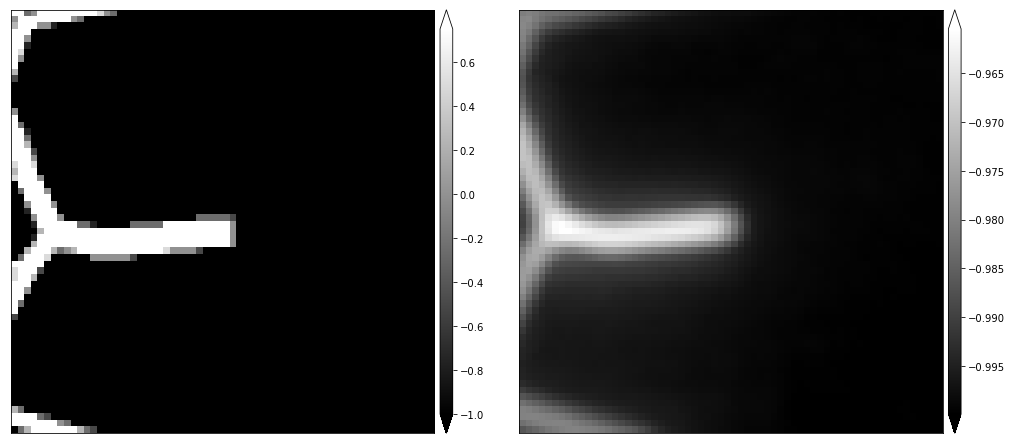

Wall time: 3.76 s


In [174]:
%%time
plot_pairs(volA=norm_vol(vol_A), volB=vol_B)

In [175]:
%%time
# p_x = discriminator.predict([expand(vol_A), expand(vol_B)]).squeeze()
# p_x = discriminator.predict([expand(vol_A), expand(vol_A)]).squeeze()
# p_x = discriminator.predict([expand(vol_A), expand(np.random.rand(64,64,32))]).squeeze()

# p_x = discriminator.predict([expand(np.random.rand(64,64,32)), expand(vol_B)]).squeeze()
# p_x = discriminator.predict([expand(vol_B), expand(vol_B)]).squeeze()
p_x = discriminator.predict([expand(norm_vol(vol_A)), expand(vol_B)]).squeeze()

Wall time: 5.63 s


In [176]:
print(p_x.shape)
print(np.min(p_x), np.median(p_x), np.mean(p_x), np.max(p_x))

(4, 4, 2)
0.061138425 0.16641149 0.16576716 0.2899368


In [231]:
def discriminator_test(D, volA, volB, start=500, end=5000, step=100):
    
    cols = ['nr', 'NPhot', 'min', 'median', 'mean', 'max']
    df = pd.DataFrame(columns=cols)
    N = int(np.ceil((end-start) / step))
    for i, NPhot in enumerate(np.arange(start, end, step)):
        # put noise to reconstruction image = x
#         print(np.min(volA), np.max(volA), np.min(volB), np.max(volB))
        x = put_noise(volA, NPhot)
        # norm image, D was trainid under this constraint
#         print(np.min(x), np.max(x))
        x = norm_vol(x)
        
#         print(np.min(x), np.max(x))
#         return 0
        # evaluate discriminator
        p_x = D.predict([expand(x), expand(volB)]).squeeze()        
        # save results of discriminator
        results = [i, NPhot, np.min(p_x), np.median(p_x), np.mean(p_x), np.max(p_x)]
        temp = pd.DataFrame(data=[results], columns=cols)
        df = df.append(temp)
    
        # print (x-times) and plot (y-times) and at the end
        if i % 3 == 0 or i == N-1:
            print('{0}/{1}\t'.format(i, N), '{0}/{1}\t'.format(NPhot, end), '(min,median,mean,max)',
                  np.min(p_x), np.median(p_x), np.mean(p_x), np.max(p_x))
        if i % 10 == 0 or i == N-1 or i == 2:
            plot_pairs(volA=x, volB=volB)
    
    return df

0/125	 0.0/25	 (min,median,mean,max) 0.027076118 0.08301328 0.09803241 0.22418334


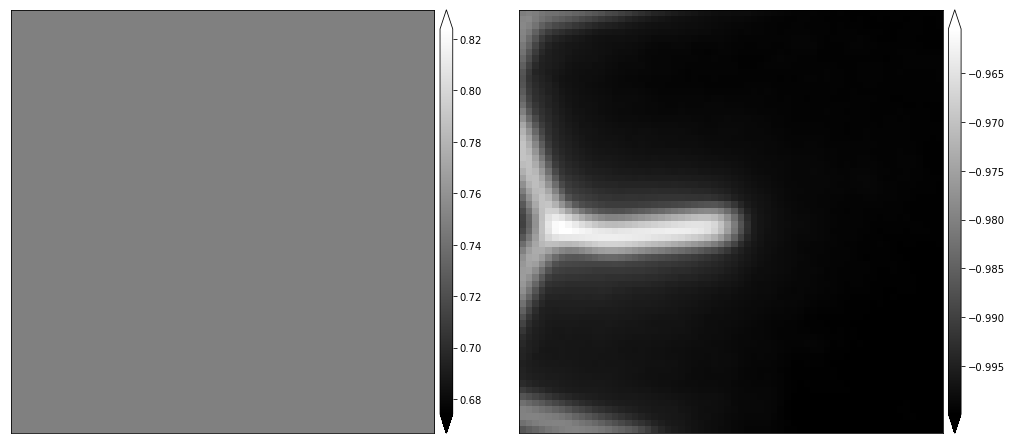

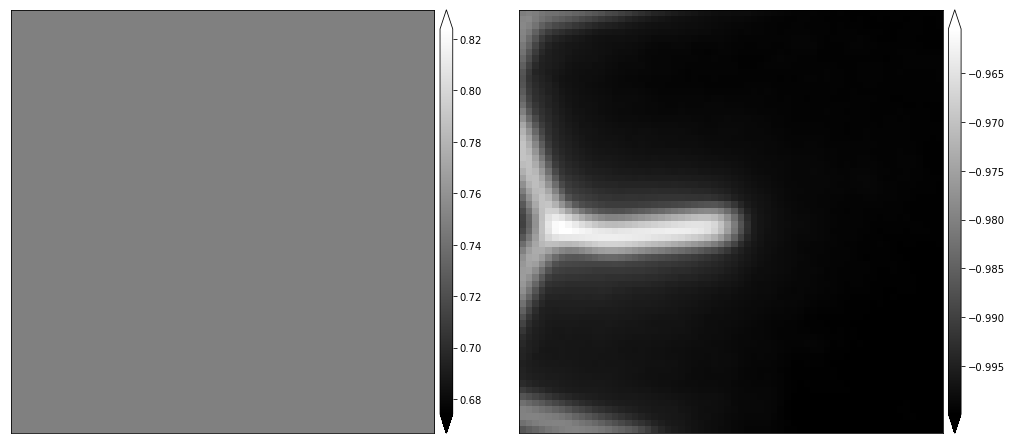

3/125	 0.6000000000000001/25	 (min,median,mean,max) 0.037199788 0.105106555 0.11431237 0.24388267
6/125	 1.2000000000000002/25	 (min,median,mean,max) 0.04420556 0.111378 0.12677003 0.26318726
9/125	 1.8/25	 (min,median,mean,max) 0.04771693 0.12316832 0.13773249 0.27835625


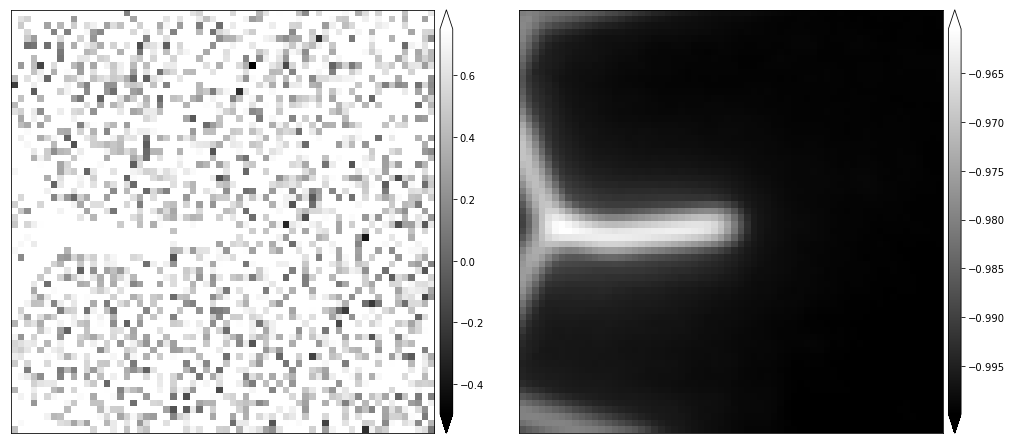

12/125	 2.4000000000000004/25	 (min,median,mean,max) 0.05225053 0.13642377 0.14421704 0.28263685
15/125	 3.0/25	 (min,median,mean,max) 0.056534298 0.14435053 0.14878954 0.28249422
18/125	 3.6/25	 (min,median,mean,max) 0.058105137 0.15023312 0.15115994 0.28188896


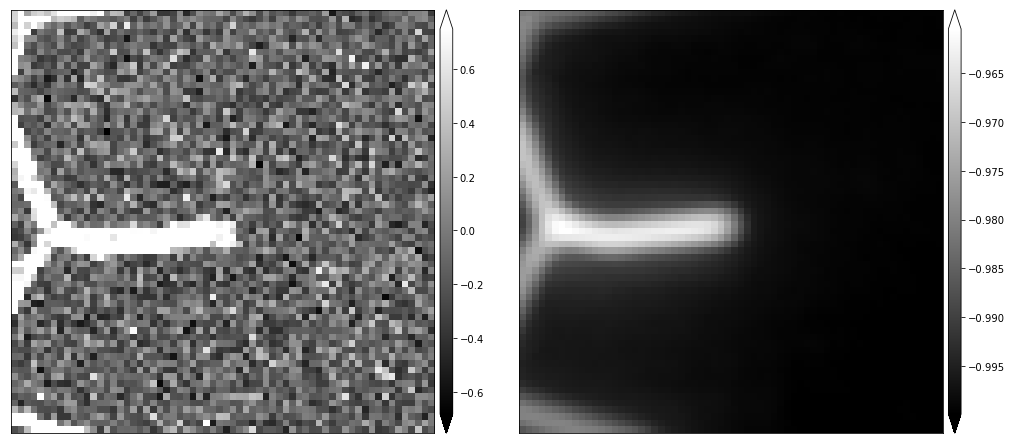

21/125	 4.2/25	 (min,median,mean,max) 0.05954978 0.15440583 0.1539481 0.2829754
24/125	 4.800000000000001/25	 (min,median,mean,max) 0.059244085 0.15608679 0.15562522 0.28298882
27/125	 5.4/25	 (min,median,mean,max) 0.05951075 0.15779379 0.15698794 0.283224
30/125	 6.0/25	 (min,median,mean,max) 0.059713475 0.15901306 0.15828317 0.28364086


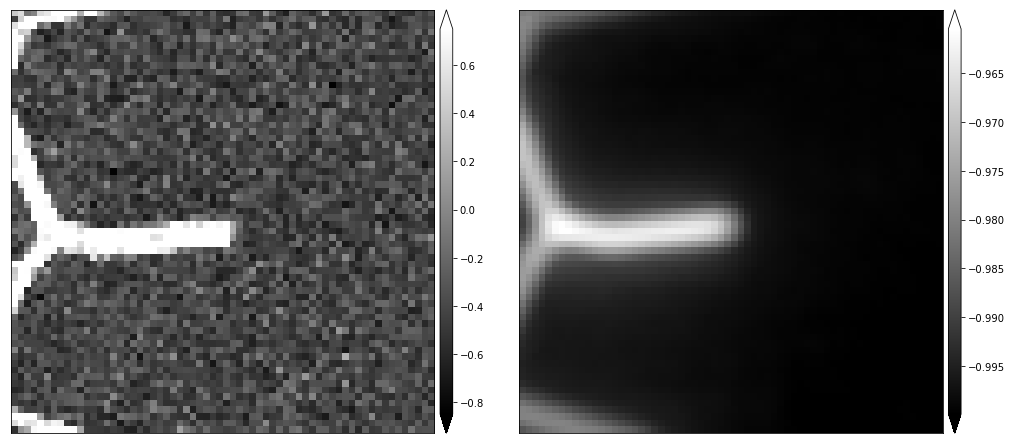

33/125	 6.6000000000000005/25	 (min,median,mean,max) 0.059735995 0.15974219 0.1589233 0.28364494
36/125	 7.2/25	 (min,median,mean,max) 0.0598634 0.160585 0.15963566 0.28399304
39/125	 7.800000000000001/25	 (min,median,mean,max) 0.060067263 0.16114217 0.16037229 0.28433904


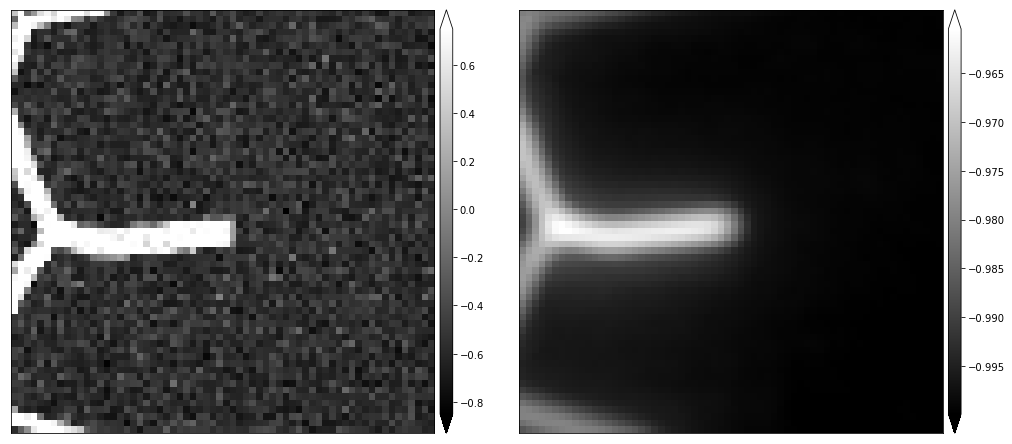

42/125	 8.4/25	 (min,median,mean,max) 0.059978046 0.16179381 0.16077411 0.28439492
45/125	 9.0/25	 (min,median,mean,max) 0.060153082 0.16207048 0.16122523 0.28492415
48/125	 9.600000000000001/25	 (min,median,mean,max) 0.060091484 0.16253957 0.16160905 0.2852014


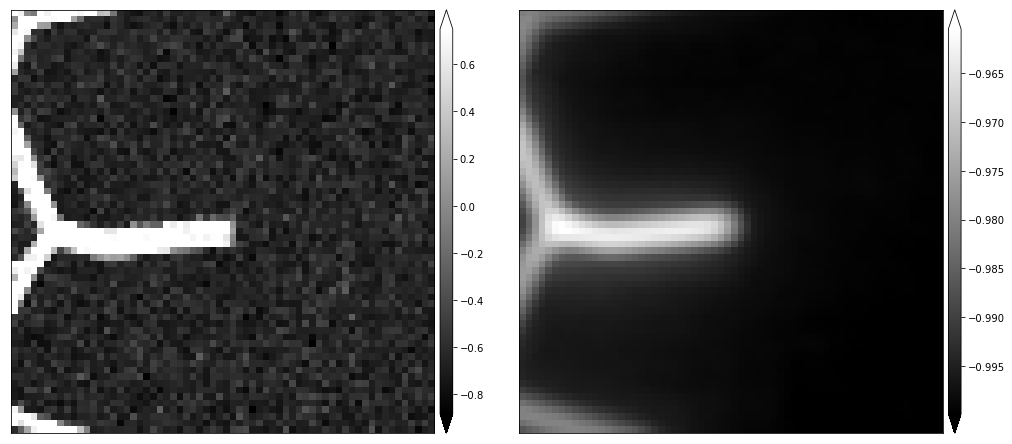

51/125	 10.200000000000001/25	 (min,median,mean,max) 0.06012033 0.16278386 0.16190915 0.285675
54/125	 10.8/25	 (min,median,mean,max) 0.06013102 0.1631487 0.1621545 0.28567782
57/125	 11.4/25	 (min,median,mean,max) 0.060317896 0.16337147 0.1624532 0.28610346
60/125	 12.0/25	 (min,median,mean,max) 0.060303945 0.16355711 0.16260877 0.28620157


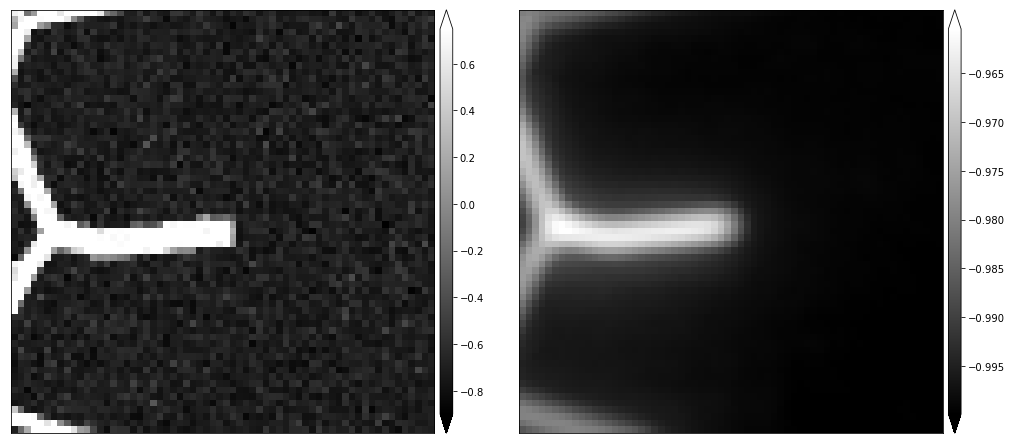

63/125	 12.600000000000001/25	 (min,median,mean,max) 0.06046393 0.1637087 0.1628426 0.28644285
66/125	 13.200000000000001/25	 (min,median,mean,max) 0.060462505 0.16383699 0.16304162 0.2866565
69/125	 13.8/25	 (min,median,mean,max) 0.06041348 0.16409542 0.1631344 0.28670868


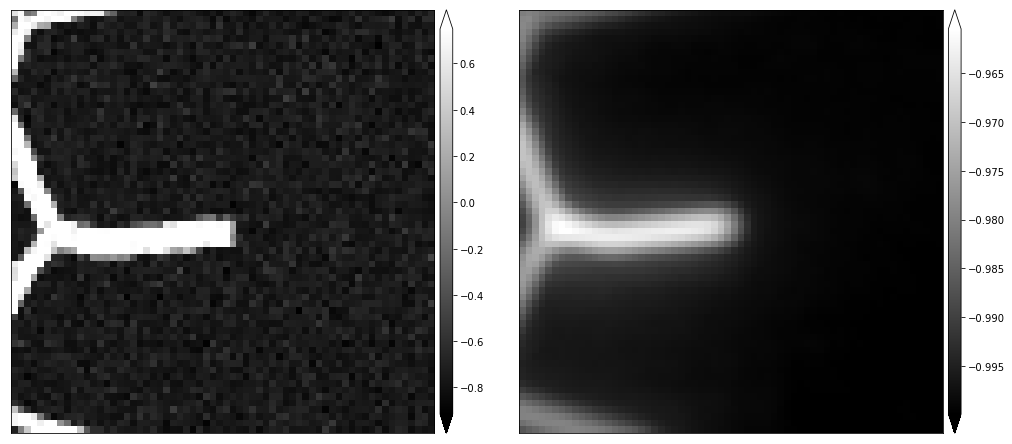

72/125	 14.4/25	 (min,median,mean,max) 0.06054672 0.16413435 0.16331187 0.2869294
75/125	 15.0/25	 (min,median,mean,max) 0.060550608 0.16433287 0.16345647 0.28711793
78/125	 15.600000000000001/25	 (min,median,mean,max) 0.06055583 0.1644215 0.16353334 0.2871589


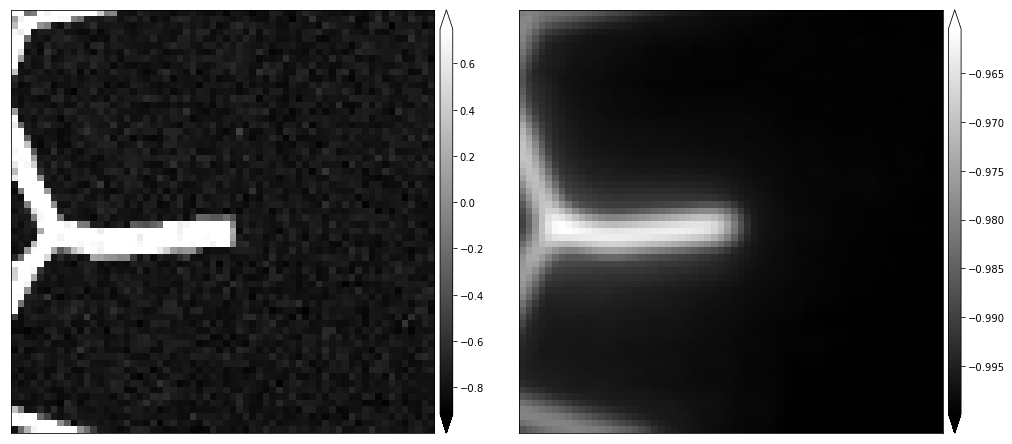

81/125	 16.2/25	 (min,median,mean,max) 0.060610536 0.16452996 0.16359809 0.2871467
84/125	 16.8/25	 (min,median,mean,max) 0.060621258 0.16446953 0.16367698 0.28739673
87/125	 17.400000000000002/25	 (min,median,mean,max) 0.060612116 0.16465318 0.16379482 0.28751922
90/125	 18.0/25	 (min,median,mean,max) 0.06062155 0.16485482 0.16389988 0.28755185


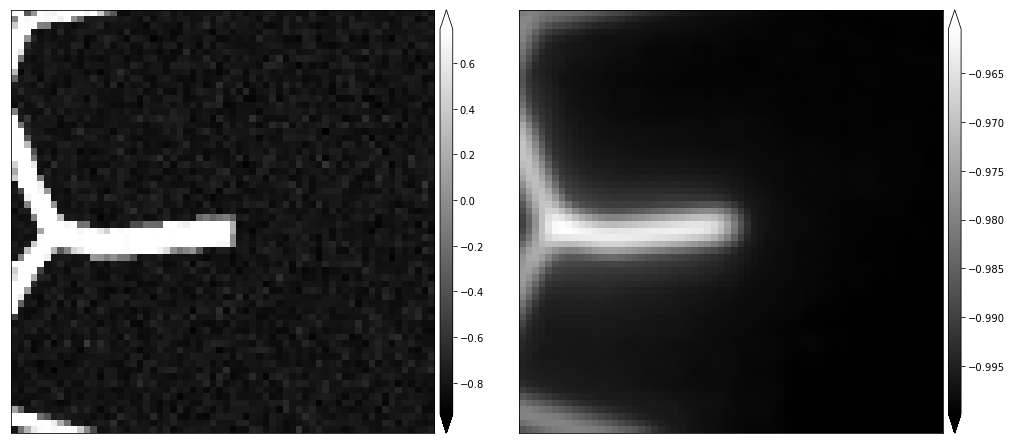

93/125	 18.6/25	 (min,median,mean,max) 0.060698934 0.16474585 0.16394588 0.28771
96/125	 19.200000000000003/25	 (min,median,mean,max) 0.06069785 0.16481611 0.16403899 0.28789905
99/125	 19.8/25	 (min,median,mean,max) 0.06076352 0.16494313 0.16409393 0.2877427


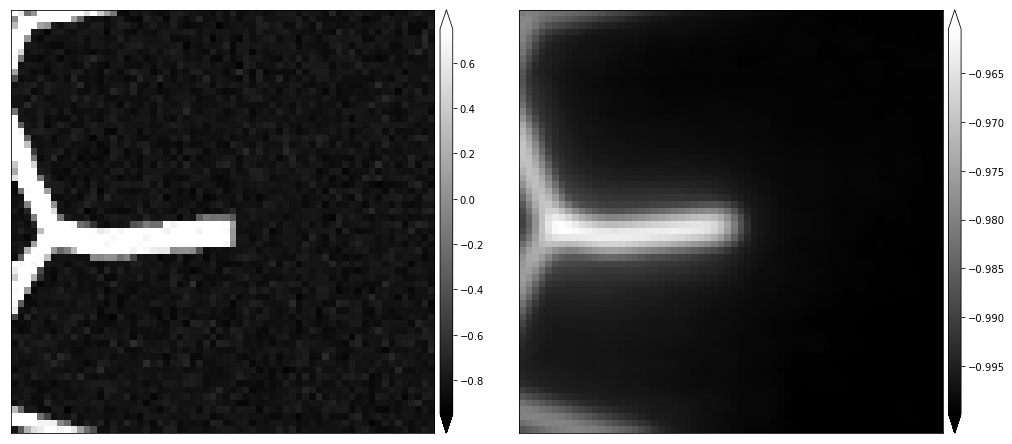

102/125	 20.400000000000002/25	 (min,median,mean,max) 0.06073343 0.16492859 0.1641105 0.2878177
105/125	 21.0/25	 (min,median,mean,max) 0.060777187 0.16498166 0.16418156 0.28800303
108/125	 21.6/25	 (min,median,mean,max) 0.060724087 0.16499084 0.16423453 0.28800774


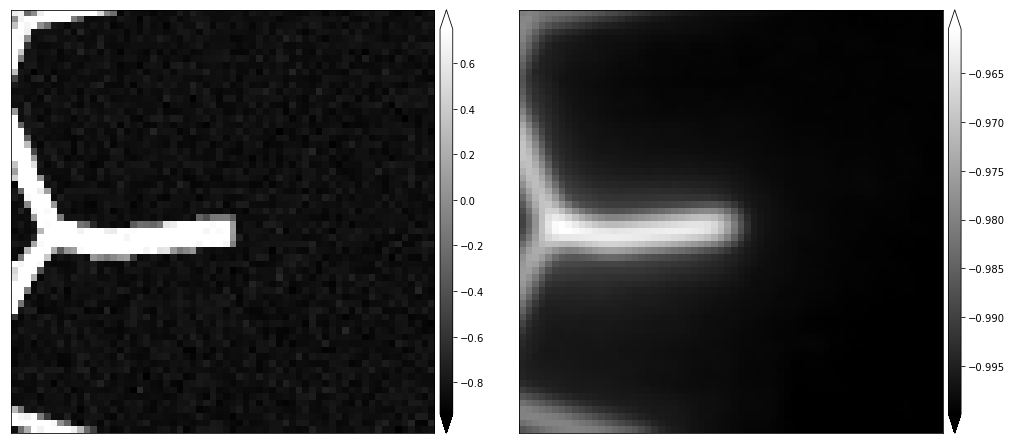

111/125	 22.200000000000003/25	 (min,median,mean,max) 0.0607547 0.16507055 0.16426122 0.28804937
114/125	 22.8/25	 (min,median,mean,max) 0.060747348 0.16511127 0.16427529 0.28813648
117/125	 23.400000000000002/25	 (min,median,mean,max) 0.060764633 0.1651806 0.16434209 0.28821194
120/125	 24.0/25	 (min,median,mean,max) 0.060764216 0.16514853 0.16432267 0.28814626


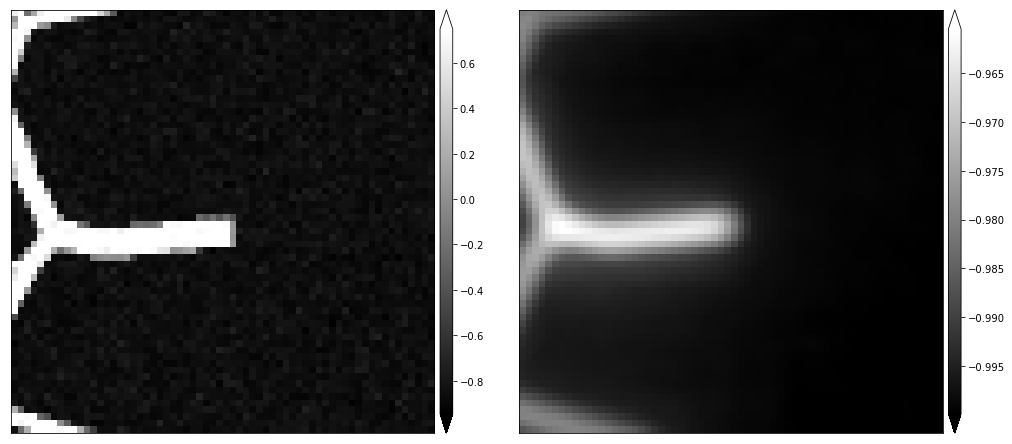

123/125	 24.6/25	 (min,median,mean,max) 0.060776357 0.16521785 0.16443165 0.28830662
124/125	 24.8/25	 (min,median,mean,max) 0.060800355 0.1652059 0.16443598 0.28830624


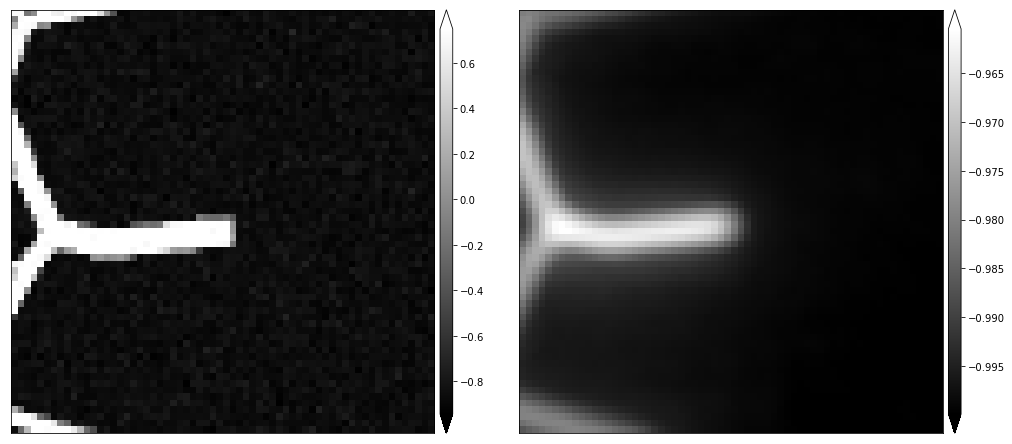

Wall time: 10min 12s


In [232]:
%%time

df = discriminator_test(D=discriminator, 
                        volA=vol_A, 
                        volB=vol_B,
                        start=0.0,
                        end=25,
                        step=0.2)

In [233]:
import time
p = time.strftime("%Y-%m-%d_%H_%M_%S")
df.to_csv('D_test_{0}.csv'.format(p), sep=',')

In [234]:
df.head()

,nr,NPhot,min,median,mean,max
0,0.0,0.0,0.027076,0.083013,0.098032,0.224183
0,1.0,0.2,0.029622,0.089594,0.102610,0.226736
0,2.0,0.4,0.034724,0.095753,0.107895,0.236363
0,3.0,0.6,0.037200,0.105107,0.114312,0.243883
0,4.0,0.8,0.039937,0.107152,0.117505,0.250353


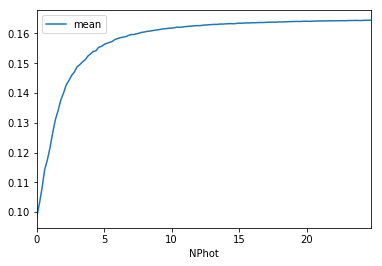

In [235]:
df.plot(x='NPhot', y='mean')

In [242]:
x, y = df['NPhot'], df['mean']
df.shape

(125, 6)

In [243]:
print(np.min(y), np.max(y), np.min(x), np.max(x))
# y = y/np.max(y)
# x = x+100
x = x + 0.5
print(np.min(y), np.max(y), np.min(x), np.max(x))

0.0980324074625969 0.1644359827041626 0.0 24.8


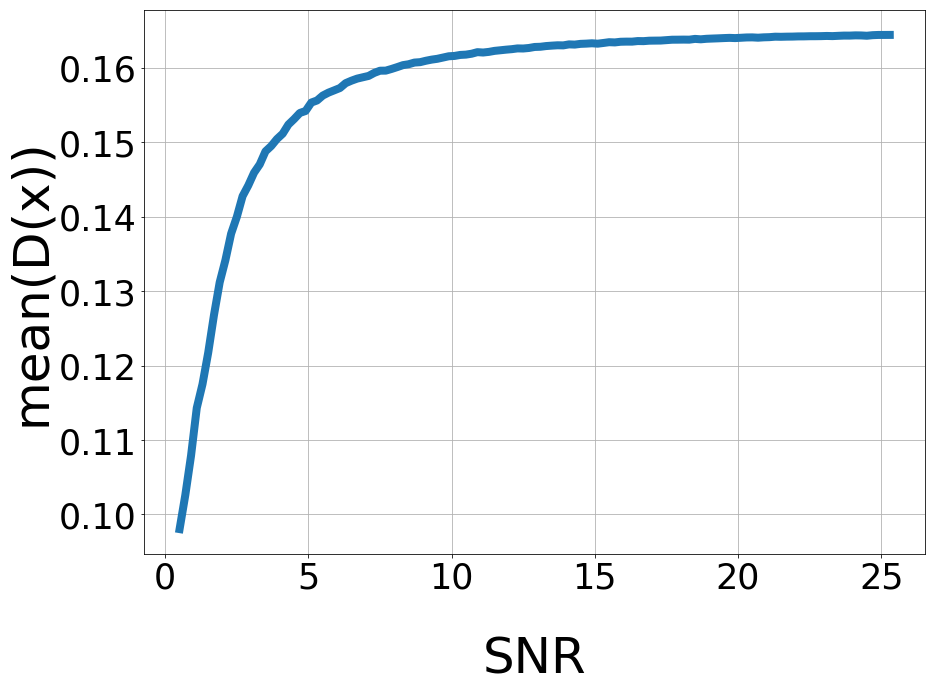

In [254]:
f = plt.figure(figsize=(14,10))
plt.plot(x,y, linewidth=8)
plt.xlabel('SNR', fontsize=50, labelpad=40); plt.ylabel('mean(D(x))', fontsize=50)
plt.xticks(fontsize=35); plt.yticks(fontsize=35) 
plt.grid(True)
plt.show()

## Compare GT with Generator output

In [249]:
def load_compare(path):
    vol = io.imread(path)
    # cut both volumes
    return hp.cut_volume(vol, (64,64,32), centered=True)    

In [246]:
validation_path = glob('./data/3D/dub/*')
len(validation_path)

84

In [247]:
# load discriminator
day_g = '2018_12_7' #'2018_12_9'
modelname_g = '09_05_39_disc' #'03_50_15_disc'

In [248]:
generator = hp.model_loader(day_g, modelname_g)

file: ./models/2018_12_7/09_05_37_disc.h5
Loaded model from disk


In [ ]:
def compare_M_G(imgs_path, G, D):
    for i, path in enumerate(imgs_path):
        vol = load_compare(path)
        
        # evaluate measurement
        M = D.predict([expand(x), expand(volB)]).squeeze() 
        
        
        generator_ D.predict([expand(x), expand(volB)]).squeeze() 